In [1]:
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from scipy import stats
import seaborn as sns

presurvey1 = "../Data/Fall 2019/CSE 8A Fall 2019 DeID/presurvey.csv"
gradebook1 = "../Data/Fall 2019/CSE 8A Fall 2019 DeID/gradebook.csv"
presurvey2 = "../Data/Fall 2019/CSE 11 Fall 2019 DeID/presurvey.csv"
gradebook2 = "../Data/Fall 2019/CSE 11 Fall 2019 DeID/gradebook.csv"
presurvey3 = "../Data/Fall 2019/CSE 12 Fall 2019 DeID/presurvey.csv"
gradebook3 = "../Data/Fall 2019/CSE 12 Fall 2019 DeID/gradebook.csv"

In [2]:
reflections2 = []
for i in range (1,9):
    reflections2.append(pd.read_csv("../Data/Fall 2019/CSE 11 Fall 2019 DeID/R" +str(i)+".csv"))

In [3]:
reflections3 = []
for i in range (1,11):
    reflections3.append(pd.read_csv("../Data/Fall 2019/CSE 12 Fall 2019 DeID/R" +str(i)+".csv"))

In [4]:
reflections1 = []
for i in range (1,9):
    reflections1.append(pd.read_csv("../Data/Fall 2019/CSE 8A Fall 2019 DeID/R" +str(i)+".csv"))

In [5]:
def scaled_categories(reflections, presurvey, category, label, x):
    categoryIssue = 0
    for i in range(x):
        category_issue = reflections[i][category]
        DeID = reflections[i]["DeID"]
        s = label + str(i) 
        cat = DataFrame({"DeID": DeID, s: category_issue})
        if i == 0:
            categoryIssue = cat
        else:
            categoryIssue = pd.merge(categoryIssue, cat, on="DeID", how="outer")
            
    categoryIssue = categoryIssue.drop_duplicates(subset=['DeID'])     
    df = pd.read_csv(presurvey)
    status = df["Did.you.enter.UCSD.as.a.transfer.student.from.another..2.year.or.4.year..college.or.university."] == "Yes"
    DeID = df["DeID"]
    transferStatus = DataFrame({"DeID": DeID, "Transfer Status": status})

    mergedData = pd.merge(transferStatus, categoryIssue, on="DeID")
    transfer = mergedData[mergedData["Transfer Status"] == True]
    native = mergedData[mergedData["Transfer Status"] == False]
    
    return {'transfer' : transfer, 'native' : native}
    

In [6]:
def RemovedOutlier(transfer, native, x, x_label):
    transferIssues = []
    nativeIssues = []
    transferMedian = []
    nativeMedian = []
    transferStd = []
    nativeStd = []
    transferLen = []
    nativeLen = []
    transferMax = []
    nativeMax = []
    transferMin = []
    nativeMin = []
    utestStatistics = []
    pValuesU = []
    TQUL = []
    TQLL = []
    NQUL = []
    NQLL = []

    for i in range(x):
        df = pd.DataFrame({label+str(i):transfer[label+str(i)],"DeID":transfer["DeID"]})
        df = df.drop_duplicates(subset=["DeID"])
        df = df.dropna(axis=0)
        l = len(df)
        Q1 = df[label+str(i)].quantile(0.25)
        Q3 = df[label+str(i)].quantile(0.75)
        IQR = Q3 - Q1    #IQR is interquartile range. 
        QLL = 0
        QUL = Q3 + 1.5 * IQR
        
        TQUL.append(QUL)
        TQLL.append(QLL)
        
        filterInclude = (df[label+str(i)] >= QLL) & (df[label+str(i)] <= QUL)   
        filterExclude = (df[label+str(i)] < QLL) | (df[label+str(i)] > QUL)
        
        df = df.loc[filterInclude]
        #print("Removed %: " + str((l - len(df))*100/l))
        transferRefined = df

        df = pd.DataFrame({label+str(i):native[label+str(i)], "DeID":native["DeID"]})
        df = df.drop_duplicates(subset=["DeID"])
        df = df.dropna(axis=0)       
        l = len(df)
        Q1 = df[label+str(i)].quantile(0.25)
        Q3 = df[label+str(i)].quantile(0.75)
        IQR = Q3 - Q1    #IQR is interquartile range. 
        QLL = 0
        QUL = Q3 + 1.5 * IQR
        
        NQUL.append(QUL)
        NQLL.append(QLL)
        
        filterInclude = (df[label+str(i)] >= QLL) & (df[label+str(i)] <= QUL)   
        filterExclude = (df[label+str(i)] < QLL) | (df[label+str(i)] > QUL)
        
        df = df.loc[filterInclude]
        #print("Removed %: " + str((l - len(df))*100/l))
        nativeRefined = df
        

        transferIssues.append(transferRefined[label+str(i)].mean())
        nativeIssues.append(nativeRefined[label+str(i)].mean())

        transferMedian.append(transferRefined[label+str(i)].median())
        nativeMedian.append(nativeRefined[label+str(i)].median())

        transferStd.append(transferRefined[label+str(i)].std())
        nativeStd.append(nativeRefined[label+str(i)].std())

        transferLen.append(len(transferRefined[label+str(i)]))
        nativeLen.append(len(nativeRefined[label+str(i)]))
        
        transferMax.append(transferRefined[label+str(i)].max())
        nativeMax.append(nativeRefined[label+str(i)].max())
        
        transferMin.append(transferRefined[label+str(i)].min())
        nativeMin.append(nativeRefined[label+str(i)].min())

        ttest_results = stats.ttest_ind(transferRefined[label+str(i)], nativeRefined[label+str(i)])
        utest_results = stats.mannwhitneyu(transferRefined[label+str(i)], nativeRefined[label+str(i)], use_continuity=False)
        utestStatistics.append(utest_results[0])
        pValuesU.append(utest_results[1])

    df = DataFrame({"Week" : Series(x_label), 
                    "Transfer Mean" : Series(transferIssues), 
                    "Native Mean" : Series(nativeIssues),
                    "Transfer Std Dev" : Series(transferStd),
                    "Native Std Dev" : Series(nativeStd),
                    "Transfer Max" : Series(transferMax),
                    "Native Max" : Series(nativeMax),
                    "Transfer Min" : Series(transferMin),
                    "Native Min" : Series(nativeMin),
                    "Transfer Number" : Series(transferLen),
                    "Native Number" : Series(nativeLen),
                    "T Upper Limit" : TQUL,
                    "N Upper Limit" : NQUL,
                    "p-value (u-test)" : pValuesU,
                    "Test Statistic (u-test)" : utestStatistics})
    return df

In [7]:
category = "At.this.time..approximately.how.many.other.students.in.this.course.would.you.be.comfortable.reaching.out.to.study.with."
label = "# of People "
graphTitle = "# of People you Feel Comfortable Reaching Out To"
X_title = "Week"
Y_title = "Number of Students"
x = 8
scale1 = "1"
scale5 = "5"

data = scaled_categories(reflections1, presurvey1, category, label, 8)
transfer1 = data['transfer']
native1 = data['native']

data = scaled_categories(reflections2, presurvey2, category, label, 8)
transfer2 = data['transfer']
native2 = data['native']

x = 10
data = scaled_categories(reflections3, presurvey3, category, label, 10)
transfer3 = data['transfer']
native3 = data['native']


In [8]:
x_label1 = ["Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9"]
x_label2 = ["Week 1", "Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9", "Week 10"]

df1 = RemovedOutlier(transfer1, native1, 8, x_label1)
df2 = RemovedOutlier(transfer2, native2, 8, x_label1)
df3 = RemovedOutlier(transfer3, native3, 10, x_label2)

In [9]:
display("CS 1:")
display(df1)
display("CS 1A:")
display(df2)
display("CS 2:")
display(df3)

'CS 1:'

,Week,Transfer Mean,Native Mean,Transfer Std Dev,Native Std Dev,Transfer Max,Native Max,Transfer Min,Native Min,Transfer Number,Native Number,T Upper Limit,N Upper Limit,p-value (u-test),Test Statistic (u-test)
0,Week 2,1.862745,2.527933,1.385924,1.604633,5.0,7.0,0.0,0.0,51,358,6.0,8.5,0.003616,7047.5
1,Week 3,1.891304,2.840541,1.464062,1.835802,5.0,9.0,0.0,0.0,46,370,6.0,9.5,0.000389,5964.5
2,Week 4,1.829787,2.994521,1.356452,1.873755,5.0,9.0,0.0,0.0,47,365,6.0,9.5,0.000011,5357.0
3,Week 5,1.886364,3.107558,1.333223,1.889838,5.0,9.0,0.0,0.0,44,344,6.0,9.5,0.000016,4697.5
4,Week 6,2.104167,3.297143,1.402727,1.982081,5.0,9.0,0.0,0.0,48,350,6.0,9.5,0.000071,5603.5
5,Week 7,2.348837,3.898396,1.494175,2.637195,5.0,12.0,0.0,0.0,43,374,7.0,12.0,0.000215,5436.5
6,Week 8,2.057143,3.926686,1.370763,2.694857,5.0,12.0,0.0,0.0,35,341,6.0,12.0,0.000013,3414.0
7,Week 9,2.047619,3.919481,1.305754,2.720727,5.0,12.0,0.0,0.0,42,385,6.0,12.0,0.000004,4722.0


'CS 1A:'

,Week,Transfer Mean,Native Mean,Transfer Std Dev,Native Std Dev,Transfer Max,Native Max,Transfer Min,Native Min,Transfer Number,Native Number,T Upper Limit,N Upper Limit,p-value (u-test),Test Statistic (u-test)
0,Week 2,1.718750,4.038194,1.419550,2.996269,5.0,12.0,0.0,0.0,32,288,6.000,12.000,1.863298e-06,2335.0
1,Week 3,2.000000,4.462633,1.460593,3.063528,5.0,13.0,0.0,0.0,31,281,6.000,14.500,2.232015e-06,2189.5
2,Week 4,2.000000,4.734483,1.388730,3.417113,5.0,15.0,0.0,0.0,29,290,6.000,17.000,1.782912e-06,2029.0
3,Week 5,2.120000,5.083624,1.536229,3.620065,5.0,16.0,0.0,0.0,25,287,6.000,16.125,3.167066e-06,1651.0
4,Week 6,2.291667,5.176678,1.517411,3.673350,5.0,15.0,0.0,0.0,24,283,7.875,16.750,1.020792e-05,1631.5
5,Week 7,2.172414,5.339161,1.582696,3.720074,6.0,17.0,0.0,0.0,29,286,6.000,18.000,1.565063e-07,1776.5
6,Week 8,2.387097,5.176080,1.686761,3.600772,7.0,17.0,0.0,0.0,31,301,8.500,18.000,1.737203e-06,2322.5
7,Week 9,2.440000,5.897059,1.583246,4.695573,5.0,20.0,0.0,0.0,25,272,8.500,20.500,9.193341e-06,1651.0


'CS 2:'

,Week,Transfer Mean,Native Mean,Transfer Std Dev,Native Std Dev,Transfer Max,Native Max,Transfer Min,Native Min,Transfer Number,Native Number,T Upper Limit,N Upper Limit,p-value (u-test),Test Statistic (u-test)
0,Week 1,2.244898,2.400000,1.639749,1.741338,5.0,8.0,0.0,0.0,49,125,8.500,8.500,0.336206,2938.0
1,Week 2,2.188679,2.347826,1.455184,1.632928,5.0,6.0,0.0,0.0,53,138,8.500,8.500,0.268229,3449.0
2,Week 3,2.377358,2.500000,1.571702,1.816981,6.0,8.0,0.0,0.0,53,142,7.000,8.500,0.471669,3738.5
3,Week 4,2.510638,3.080882,1.816259,2.666820,8.0,10.0,0.0,0.0,47,136,8.500,10.375,0.208387,2945.0
4,Week 5,2.465116,2.490909,1.943841,1.795741,8.0,8.0,0.0,0.0,43,110,8.500,8.500,0.426371,2320.0
5,Week 6,2.390244,2.800000,1.282148,1.969950,5.0,8.0,0.0,0.0,41,115,7.000,9.500,0.204817,2156.0
6,Week 7,2.512195,2.704000,1.645022,1.938673,7.0,8.0,0.0,0.0,41,125,7.000,9.500,0.334285,2450.0
7,Week 8,3.041667,2.904762,2.510485,2.581767,10.0,10.0,0.0,0.0,24,84,10.125,11.000,0.353943,958.0
8,Week 9,2.583333,2.869565,1.665942,2.644577,7.0,10.0,0.0,0.0,24,92,7.000,11.000,0.409801,1071.0
9,Week 10,2.812500,3.235294,1.635050,2.610627,8.0,10.0,0.0,0.0,32,102,9.500,11.000,0.337434,1552.5


Text(0, 0.5, 'Number of Students')

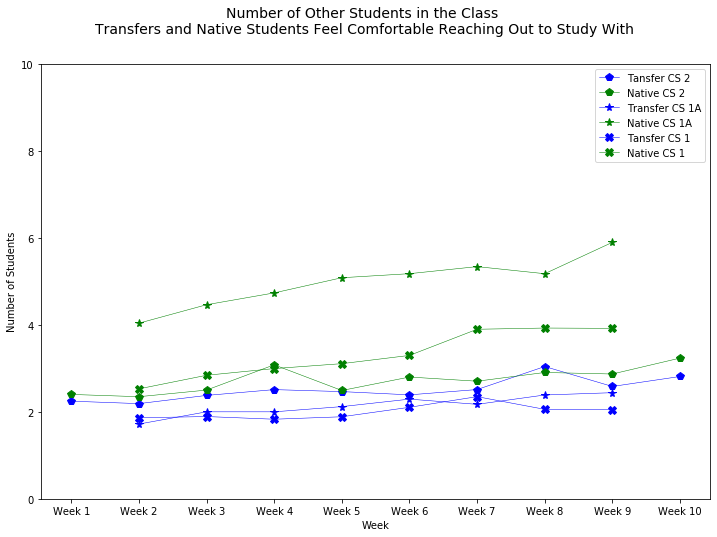

In [10]:
X_label = ""
Y_label = "# of Students"
graphTitle = "Number of Other Students in the Class \nTransfers and Native Students Feel Comfortable Reaching Out to Study With"

plt.figure(figsize=(12,8))
plt.plot(x_label2, df3["Transfer Mean"], "-p", color='blue' , linewidth=0.5, markersize=8)
plt.plot(x_label2, df3["Native Mean"], "-p", color='green', linewidth=0.5, markersize=8)
plt.plot(x_label1, df2["Transfer Mean"], "-*", color='blue', linewidth=0.5, markersize=8)
plt.plot(x_label1, df2["Native Mean"], "-*", color='green', linewidth=0.5, markersize=8)
plt.plot(x_label1, df1["Transfer Mean"], "-X", color='blue', linewidth=0.5, markersize=8)
plt.plot(x_label1, df1["Native Mean"], "-X", color='green', linewidth=0.5, markersize=8)
plt.legend(['Tansfer CS 2', 'Native CS 2', 'Transfer CS 1A','Native CS 1A', 'Tansfer CS 1', 'Native CS 1'])
plt.ylim(0, 10)
plt.suptitle(graphTitle, fontsize=14)
plt.xlabel(X_title, fontsize=10)
plt.ylabel(Y_title, fontsize=10)

In [14]:
fig = go.Figure(layout=go.Layout(yaxis=dict(range=[0,6.25])))

fig.add_trace(go.Scatter(x=x_label2, y=df3["Transfer Mean"],
                    mode='lines+markers',
                    name='Transfer CS 2',
                    marker_symbol="square",
                    marker=dict(
                        color='#69c6af',
                        size=5,
                        line=dict(
                                color='#52bca3',
                                width=5
                            )
                        )
               ))
fig.add_trace(go.Scatter(x=x_label2, y=df3["Native Mean"],
                    mode='lines+markers',
                    name='Native CS 2',
                    marker_symbol="circle-dot",
                    marker=dict(
                        color='#69c6af',
                        size=5,
                        line=dict(
                                color='#52bca3',
                                width=5
                            )
                        )
               ))

fig.add_trace(go.Scatter(x=x_label1, y=df2["Transfer Mean"],
                    mode='lines+markers',
                    name='Transfer CS 1A',
                    marker_symbol="square",
                    marker=dict(
                        color='#9a61b0',
                        size=5,
                        line=dict(
                                color='#5d69b1',
                                width=5
                            )
                        )
               ))
fig.add_trace(go.Scatter(x=x_label1, y=df2["Native Mean"],
                    mode='lines+markers',
                    name='Native CS 1A',
                    marker_symbol="circle-dot",
                    marker=dict(
                        color='#9a61b0',
                        size=5,
                        line=dict(
                                color='#5d69b1',
                                width=5
                            )
                        )
               ))

fig.add_trace(go.Scatter(x=x_label1, y=df1["Transfer Mean"],
                    mode='lines+markers',
                    name='Transfer CS 1',
                    marker_symbol="square",
                    marker=dict(
                        color='#c7a302',
                        size=5,
                        line=dict(
                                color="#e58606",
                                width=5
                            )
                        )
             ))
fig.add_trace(go.Scatter(x=x_label1, y=df1["Native Mean"],
                    mode='lines+markers',
                    name='Native CS 1',
                    marker_symbol="circle-dot",
                    marker=dict(
                        color='#c7a302',
                        size=5,
                        line=dict(
                                color='#e58606',
                                width=5
                            )
                        )
               ))


fig.update_layout(
                  xaxis_title="<b>Week</b>",
                  height=525,
                  width = 950,
                  yaxis_title="<b>Number of Students</b>",
                  legend_title="<b>Legend</b>",
                 )


fig.show()